In [77]:
import pickle
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_curve, auc,roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [13]:
with open('train_features1.pkl',mode='rb')as file:
    train_features1=pickle.load(file)
with open('train_labels.pkl',mode='rb')as file:
    train_labels=pickle.load(file)
with open('test_features1.pkl',mode='rb')as file:
    test_features1=pickle.load(file)
with open('test_labels.pkl',mode='rb')as file:
    test_labels=pickle.load(file)
with open('dataframe.pkl',mode='rb')as file:
    df=pickle.load(file)

In [14]:
svc_0 =svm.SVC(random_state=8)

print('Parameters currently in use:\n')
pprint(svc_0.get_params())

Parameters currently in use:

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 8,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [15]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [ 0.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)


{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [16]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(train_features1,train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
FINISHED--------------------


In [17]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9127470463445105


In [42]:
C = [ .01, .1, 1]
degree = [3, 4]
gamma = [ 10, 100]
probability = [True,False]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'],'degree':degree,  'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features1, train_labels)
print('FINISHED--------------------------')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
FINISHED--------------------------


In [43]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1, 'degree': 3, 'kernel': 'rbf', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9621333333333334


In [44]:
best_svc = grid_search.best_estimator_
best_svc

SVC(C=1, probability=True, random_state=8)

In [45]:
best_svc.fit(train_features1,train_labels)

SVC(C=1, probability=True, random_state=8)

In [46]:
svc_pred = best_svc.predict(test_features1)

In [47]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_svc.predict(train_features1)))

The training accuracy is: 
0.9989423585404548


In [48]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, svc_pred))

The test accuracy is: 
0.9491017964071856


In [80]:
# Classification report
print("Classification report for SVM model")
print(classification_report(test_labels,svc_pred))

Classification report for SVM model
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.92      0.94      0.93        49
           2       0.95      0.93      0.94        60
           3       0.90      0.99      0.94        81
           4       1.00      0.89      0.94        72

    accuracy                           0.95       334
   macro avg       0.95      0.95      0.95       334
weighted avg       0.95      0.95      0.95       334



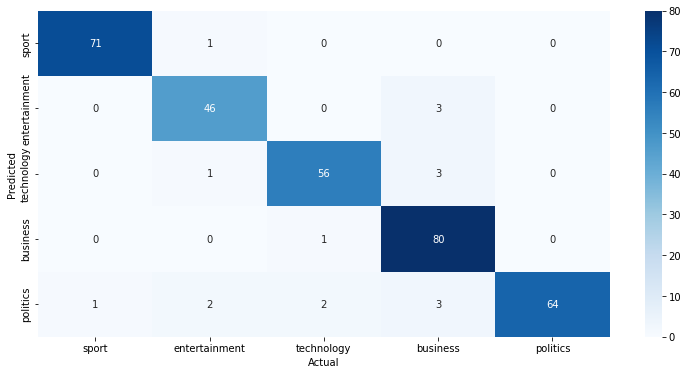

In [79]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, svc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.savefig('SVM1_confision.png',bbox_inches = "tight")

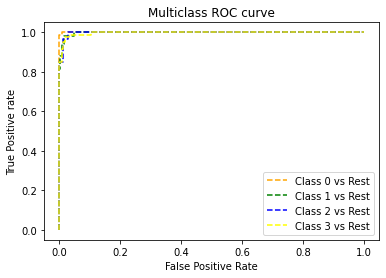

In [75]:
fpr = {}
tpr = {}
thresh ={}
y_prob_pred_cnb = best_svc.predict_proba(test_features1)
n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(test_labels, y_prob_pred_cnb[:,i], pos_label=i)
    
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC');

In [78]:
roc_auc_score(test_labels, y_prob_pred_cnb, multi_class='ovo', average='weighted')

0.9979483776211748

# Second features

In [55]:
with open('train_features2.pkl',mode='rb')as file:
    train_features2=pickle.load(file)
with open('test_features2.pkl',mode='rb')as file:
    test_features2=pickle.load(file)

In [ ]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [ 0.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Create the random grid
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)




In [57]:
# First create the base model to tune
svc = svm.SVC(random_state=8)

# Definition of the random search
random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model
random_search.fit(train_features2,train_labels)
print('FINISHED--------------------')

Fitting 3 folds for each of 50 candidates, totalling 150 fits
FINISHED--------------------


In [58]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.9053438314928014


In [59]:
C = [ .01, .1, 1]
degree = [3, 4]
gamma = [ 10, 100]
probability = [True,False]

param_grid = [
  {'C': C, 'kernel':['linear'], 'probability':probability},
  {'C': C, 'kernel':['poly'], 'degree':degree, 'probability':probability},
  {'C': C, 'kernel':['rbf'],'degree':degree,  'probability':probability}
]

# Create a base model
svc = svm.SVC(random_state=8)

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(train_features2, train_labels)
print('FINISHED--------------------------')

Fitting 3 folds for each of 30 candidates, totalling 90 fits
FINISHED--------------------------


In [60]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'C': 1, 'degree': 3, 'kernel': 'rbf', 'probability': True}

The mean accuracy of a model with these hyperparameters is:
0.9696000000000001


In [61]:
best_svc2 = grid_search.best_estimator_
best_svc2

SVC(C=1, probability=True, random_state=8)

In [62]:
best_svc2.fit(train_features2,train_labels)

SVC(C=1, probability=True, random_state=8)

In [63]:
svc_pred2 = best_svc2.predict(test_features2)

In [64]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(train_labels, best_svc2.predict(train_features2)))

The training accuracy is: 
0.9994711792702274


In [65]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(test_labels, svc_pred2))

The test accuracy is: 
0.9461077844311377


In [66]:
# Classification report
print("Classification report")
print(classification_report(test_labels,svc_pred2))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.92      0.92      0.92        49
           2       0.95      0.93      0.94        60
           3       0.89      0.99      0.94        81
           4       1.00      0.89      0.94        72

    accuracy                           0.95       334
   macro avg       0.95      0.94      0.94       334
weighted avg       0.95      0.95      0.95       334



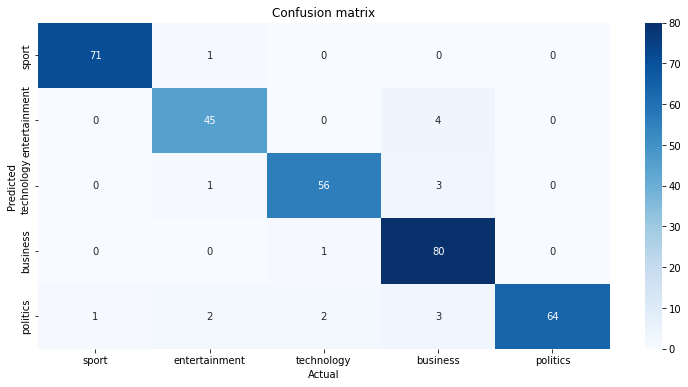

In [67]:
aux_df = df[['Category', 'CategoryID']].drop_duplicates().sort_values('CategoryID')
conf_matrix = confusion_matrix(test_labels, svc_pred2)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

# base model

In [68]:
base_model = svm.SVC(random_state = 8)
base_model.fit(train_features1, train_labels)
accuracy_score(test_labels, base_model.predict(test_features1))

0.9491017964071856

In [69]:
best_svc.fit(train_features1, train_labels)
accuracy_score(test_labels, best_svc.predict(test_features1))

0.9491017964071856

In [70]:
base_model = svm.SVC(random_state = 8)
base_model.fit(train_features2, train_labels)
accuracy_score(test_labels, base_model.predict(test_features2))

0.9461077844311377

In [71]:
best_svc2.fit(train_features2, train_labels)
accuracy_score(test_labels, best_svc2.predict(test_features2))

0.9461077844311377

In [73]:

d = {
     'Model': ['SVM1','SVM2'],
     'Training Set Accuracy': [accuracy_score(train_labels, best_svc.predict(train_features1)),
                               accuracy_score(train_labels, best_svc2.predict(train_features2))],
     'Test Set Accuracy': [accuracy_score(test_labels, svc_pred),accuracy_score(test_labels, svc_pred2)]
}

df_models_svc = pd.DataFrame(d)
df_models_svc

,Model,Training Set Accuracy,Test Set Accuracy
0,SVM1,0.998942,0.949102
1,SVM2,0.999471,0.946108


In [81]:
df_models_svc.to_pickle('SVM.accuracy.pkl')